# Predicting Monthly Electricity Consumption (Machine Learning)

Project : Predicting Monthly Electricity Consumption 

Build a Machine learning model for each sector :
1. Split the data into train, validation and test set
2. Use random forest regression to select feature by feature of important 
3. Train the model on the training+validation set and predict on the test set

Add the prediction from the three sectors to get the total consumption. 

# Import libraries and define functions

In [635]:
# import the library
import sys
import feather
import pickle
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%matplotlib inline

from fastai.imports import *


from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold

from IPython.display import display
import seaborn as sns
import folium

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
def three_split(df,y):
    '''split data into train, validation and test 
    this is a time series data, thus no shuffle
    '''
    test_idxs = int(df.shape[0]*0.85)
    X_test = df.iloc[test_idxs:]
    y_test = y[test_idxs:]
    val_idxs = int(df.shape[0]*0.85*0.75)
    
    X_trn = df.iloc[:val_idxs]
    y_trn = y[:val_idxs]

    X_val = df.iloc[val_idxs:test_idxs]
    y_val = y[val_idxs:test_idxs]
    
    return (X_trn,y_trn,X_val,y_val,X_test,y_test)

In [199]:
def two_split(df,y):
    '''split data into train, validation and test 
    this is a time series data, thus no shuffle
    '''
    test_idxs = int(df.shape[0]*0.85)
    X_test = df.iloc[test_idxs:]
    y_test = y[test_idxs:]
    
    X_trn = df.iloc[:test_idxs]
    y_trn = y[:test_idxs]
    
    return (X_trn,y_trn,X_test,y_test)

In [231]:
def do_search(X_trn,y_trn):
    ''' randomize search for randomforest regressor
    return the best estimator'''
    # rf 
    m = RandomForestRegressor(n_jobs=-1, random_state=42)
    
    param_dist = {'n_estimators':range(20,200,20),
              'max_depth': [3, None],
              'min_samples_split' : [2, 5, 10], 
              'max_features' : range(2,X_trn.shape[1]),
               'bootstrap' : [True, False],
              'min_samples_leaf': range(1, 8)}
    
    #hyper parameter tuning
    search = RandomizedSearchCV(m, param_distributions=param_dist,
                            n_iter=100,n_jobs=-1, cv=5, random_state=40)
    
    search.fit(X_trn,y_trn)
    print(search.best_params_, search.best_score_)
    
    return search.best_estimator_

In [198]:
def make_dedo(df):
    '''create a dendogram showing redundant features'''
    corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))
    
    for i in range(corr.shape[0]):
        corr[i,i] = 1
    
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr, method='average')
    fig = plt.figure(figsize=(16,10))
    dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
    plt.show()

In [200]:
def print_score(m,Xtrn=X_trn,ytrn=y_trn,Xval=X_val,yval=y_val):
    '#print score print  rmse, and r2 score and return these scores'
    res = [mean_squared_error(m.predict(Xtrn), ytrn),
           mean_squared_error(m.predict(Xval), yval), 
           m.score(Xtrn, ytrn),
           m.score(Xval, yval)]
    # if rf has bagging, print the oob score, also
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    #print('Training loss \t Val loss \t Train R2 \t Val R2')
    print(res)
    return res

In [201]:
def plot_score(m,res,val=False):
    
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    if val:
        x = ['train','val','test']
        c = ['royalblue','orange','red']
        res = np.insert(res,2,mean_squared_error(m.predict(X_test),y_test))
        res = np.append(res,m.score(X_test,y_test))
        print(res)
    else:
        x = ['train', 'test']
        c = ['royalblue','red']

    ax[0].bar(x=x, height=res[:len(x)],width=0.5,edgecolor ='black',color =c)
    ax[0].set_title('RMSE loss')
    
    for i in range(len(x)):
        ax[0].text(s=f'{res[i].round(2)}',x=i, y=res[i].round(2)*0.7,horizontalalignment='center')
  
    ax[1].bar(x=x, height=res[len(x):],width=0.5,edgecolor ='black',color =c)
    ax[1].set_title('R2 Score')
    
    for i in range(len(x)):
        ax[1].text(s=f'{res[len(x)+i].round(2)}',x=i, y=res[len(x)+i].round(2)*0.7,horizontalalignment='center')   

# Load Data

In [425]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'
mfolder = 'E:/Users/Fern/energy_data/'
# load the data 
combine = pd.read_csv(cleanfolder+'combine.csv').dropna()
combine['Year-Month'] = pd.to_datetime(combine['Year-Month'])
# set State and Regions columns as category 
combine['State'] = combine['State'].astype('category')
combine['Regions'] = combine['Regions'].astype('category')
combine.head()

,Year,Month,State,Sale_RES,Sale_COM,Sale_IND,Sale_OTH,Sale_ALL,Price_RES,Price_COM,...,Heating_deg_days,Cooling_deg_days,Pop,Income,UR,GSP,CPI,Regions,Year-Month,Sale_ALL_no_OTH
1,1990,1,AL,2070.09,820.42,2099.55,53.95,5044.01,5.96,6.64,...,517.0,21.0,4036.801,64029.4,6.7,71085.0,132.0,East South Central,1990-01-01,4990.06
2,1990,1,AR,1026.32,474.99,782.49,47.60,2331.40,7.06,6.52,...,620.0,5.0,2347.535,34283.2,6.7,38109.0,132.0,West South Central,1990-01-01,2283.80
3,1990,1,AZ,1396.50,1081.79,809.80,151.06,3439.15,7.83,7.64,...,523.0,0.0,3668.417,63546.7,5.2,69322.0,132.0,Mountain,1990-01-01,3288.09
4,1990,1,CA,6168.01,6011.77,4454.66,869.56,17504.01,9.68,8.46,...,552.0,0.0,29863.502,640724.9,5.2,788322.0,132.0,Pacific Contiguous,1990-01-01,16634.44
5,1990,1,CO,1046.80,1158.96,545.39,58.78,2809.94,6.81,5.62,...,1144.0,0.0,3294.308,65348.5,5.4,74206.0,132.0,Mountain,1990-01-01,2751.15


In [426]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Year-Month', 'Sale_ALL_no_OTH'],
      dtype='object')

# Machine Learning

## Predicting Residential Consumption

In [458]:
#predict column 
pre_col = 'Sale_RES'
use_col = ['Year', 'Month', 'State','Cus_RES','Price_RES', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI','Regions']

skip_col = [x for x in raw.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the state column with 49 catergory
df, y, nas = proc_df(combine, pre_col,skip_flds=skip_col, max_n_cat=51)

In [459]:
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m_res = do_search(X_trn,y_trn)

m_res.fit(X_trn,y_trn)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 33, 'max_depth': None, 'bootstrap': False} 0.9777802105188054


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=33, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[2365.874476481805, 142359.00791998324, 0.999391303268866, 0.9751631284882549]
[  2365.87448 142359.00792 259513.04708      0.99939      0.97516      0.9593 ]


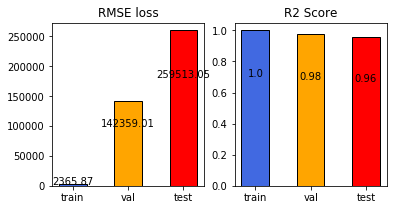

In [460]:
# print and plot train, validation and test score 
result = print_score(m_res,X_trn,y_trn,X_val,y_val)
plot_score(m_res,result,val=True)

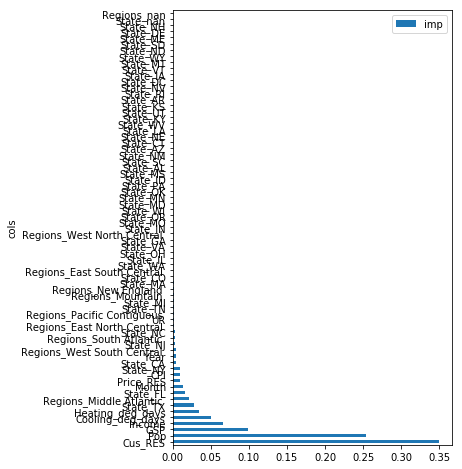

In [461]:
# calculate feature of importance
fi = rf_feat_importance(m_res, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

In [462]:
# drop features with low importance 
to_drop = fi[fi.imp <0.01].cols
df_drop = df.drop(to_drop,axis=1)

In [463]:
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop,y)
m_res = do_search(X_trn,y_trn)

m_res.fit(X_trn,y_trn)

{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 7, 'max_depth': None, 'bootstrap': True} 0.965681570196273


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[7422.549921962015, 235223.33293298335, 0.9980903120942852, 0.9589614188664148]
[  7422.54992 235223.33293 454690.13986      0.99809      0.95896      0.92868]


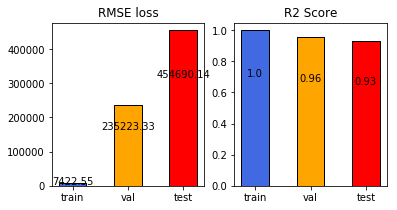

In [464]:
result = print_score(m_res,X_trn,y_trn,X_val,y_val)
plot_score(m_res, result,val=True)

[7276.638504789629, 173114.64868306566, 0.9983387031539034, 0.9728468039996758]


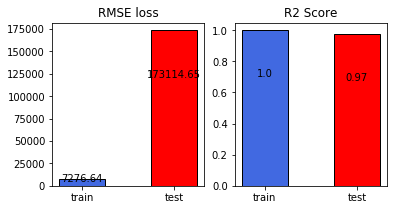

In [465]:
# split data into training, validation and test sets
X_trn,y_trn,X_test,y_test = two_split(df_drop,y)

m_res.fit(X_trn,y_trn)
# score
result = print_score(m_res,X_trn,y_trn,X_test,y_test)
plot_score(m_res, result,val=False)

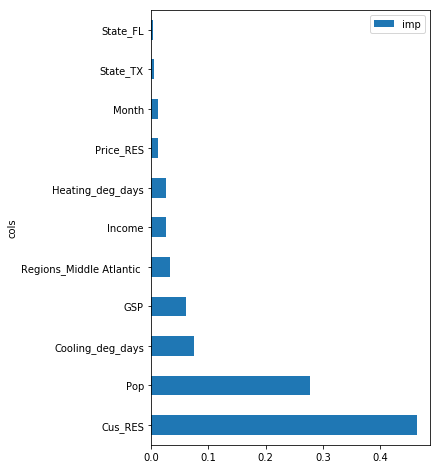

In [466]:
# calculate feature of importance
fi_res = rf_feat_importance(m_res, X_trn)
fi_res.plot('cols','imp',kind='barh',figsize=(5,8))

In [467]:
# save train model 
pickle.dump(m_res, open('model/res_model.pkl', 'wb'))
#sort fi df by X_trn columns order 
fi_res['cols'] = pd.Categorical(fi_res['cols'], X_trn.columns)
fi_res = fi_res.sort_values('cols')
# save feature of importance 
fi_res.to_csv('model/res_feature_importance.csv',index=False)

## Predicting Industry Consumption

In [468]:
#predict column 
pre_col = 'Sale_IND'
use_col = ['Year', 'Month', 'State','Cus_IND','Price_IND', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI','Regions']

skip_col = [x for x in raw.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, indicate the target column
# one hot encode the state column with 49 catergory
df, y, nas = proc_df(combine, pre_col,skip_flds=skip_col, max_n_cat=49)

In [469]:
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)
m_ind = do_search(X_trn,y_trn)

m_ind.fit(X_trn,y_trn)

{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 16, 'max_depth': None, 'bootstrap': False} 0.9745205961311972


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=16, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[3.7889629076843863e-25, 124580.59795329307, 1.0, 0.9465306385486338]
[     0.      124580.59795 202560.64074      1.           0.94653      0.92175]


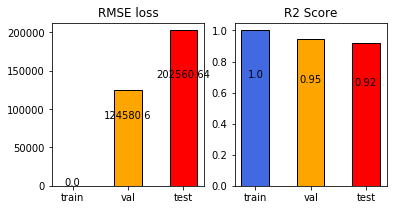

In [470]:
result = print_score(m_ind,X_trn,y_trn,X_val,y_val)
# train, validation and test set score 
plot_score(m_ind,result,val=True)

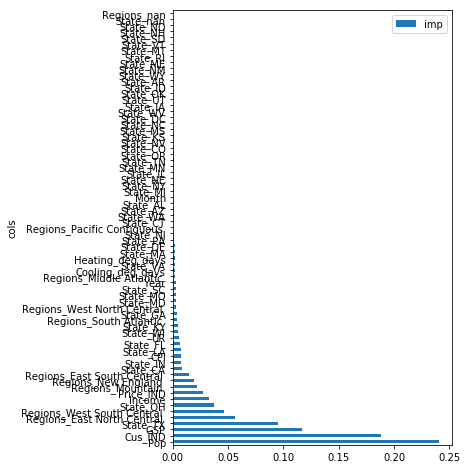

In [471]:
# calculate feature of importance
fi = rf_feat_importance(m_ind, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

In [472]:
# drop features with low importance 
to_drop = fi[fi.imp <0.01].cols
df_drop = df.drop(to_drop,axis=1)

In [473]:
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop,y)
m_ind = do_search(X_trn,y_trn)

m_ind.fit(X_trn,y_trn)

{'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': None, 'bootstrap': False} 0.9578926092100698


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=140, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[2020.8123004563056, 153397.9654738664, 0.9992065259727234, 0.9341623704125949]
[  2020.8123  153397.96547 338062.24612      0.99921      0.93416      0.86941]


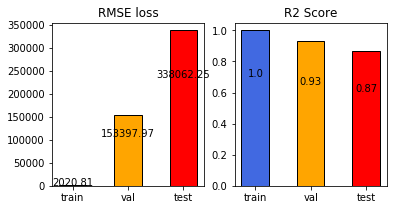

In [474]:
result= print_score(m_ind,X_trn,y_trn,X_val,y_val)
plot_score(m_ind, result,val=True)

[1897.122582444845, 132793.22776673437, 0.9992391893336854, 0.9487041080492261]


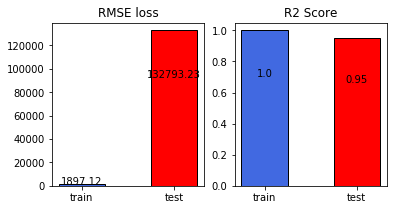

In [475]:
# split data into training, validation and test sets
X_trn,y_trn,X_test,y_test = two_split(df_drop,y)

m_ind.fit(X_trn,y_trn)
result= print_score(m_ind,X_trn,y_trn,X_test,y_test)
plot_score(m_ind, result,val=False)

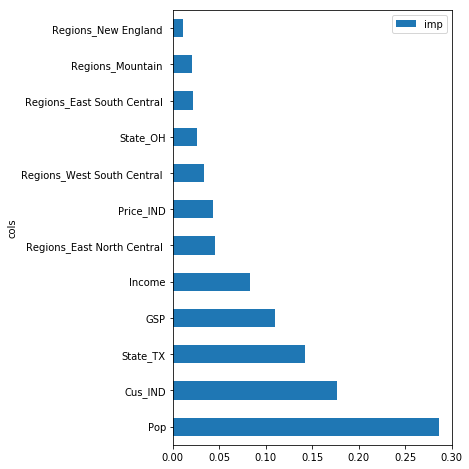

In [476]:
# calculate feature of importance
fi_ind = rf_feat_importance(m_ind, X_trn)
fi_ind.plot('cols','imp',kind='barh',figsize=(5,8))

In [477]:
# save train model 
pickle.dump(m_ind, open('model/ind_model.pkl', 'wb'))
#sort fi df by X_trn columns order 
fi_ind['cols'] = pd.Categorical(fi_ind['cols'], X_trn.columns)
fi_ind = fi_ind.sort_values('cols')
# save feature of importance 
fi_ind.to_csv('model/ind_feature_importance.csv',index=False)

## Predicting Commercial Consumption

In [478]:
#predict column 
pre_col = 'Sale_COM'
use_col = ['Year', 'Month', 'State','Cus_COM','Price_COM', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI','Regions']

skip_col = [x for x in raw.columns if x not in use_col + [pre_col]]

#put the training set into proc_df, COMicate the target column
# one hot encode the state column with 49 catergory
df, y, nas = proc_df(combine, pre_col,skip_flds=skip_col, max_n_cat=49)
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df,y)

In [479]:
# hyper parameter tuning and 
m_com = do_search(X_trn,y_trn)
# fit the model 
m_com.fit(X_trn,y_trn)

{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 30, 'max_depth': None, 'bootstrap': False} 0.9843401917869193


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=160, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[1072.6094029736505, 110020.20721234445, 0.9996613190771604, 0.9793426106382949]
[  1072.6094  110020.20721 278437.29899      0.99966      0.97934      0.95143]


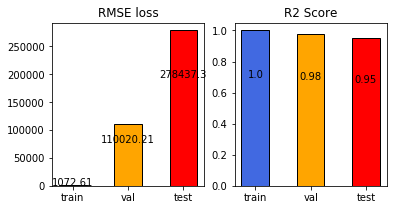

In [480]:
result= print_score(m_com,X_trn,y_trn,X_val,y_val)
# train, validation and test set score 
plot_score(m_com,result,val=True)

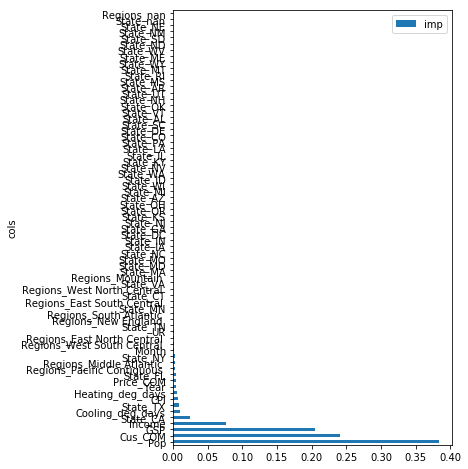

In [481]:
# calculate feature of importance
fi = rf_feat_importance(m_com, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,8))

In [482]:
# drop features with low importance 
to_drop = fi[fi.imp <0.05].cols
df_drop = df.drop(to_drop,axis=1)

In [483]:
# split data into training, validation and test sets
X_trn,y_trn,X_val,y_val,X_test,y_test = three_split(df_drop,y)
m_com = do_search(X_trn,y_trn)

m_com.fit(X_trn,y_trn)

{'n_estimators': 60, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 3, 'max_depth': None, 'bootstrap': True} 0.9451503594122141


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=7,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

[48349.683185294474, 245951.90907858702, 0.9847333845155529, 0.9538200801577748]
[ 48349.68319 245951.90908 465532.03861      0.98473      0.95382      0.91879]


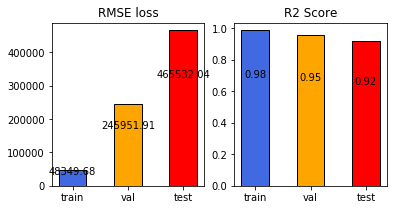

In [484]:
result = print_score(m_com,X_trn,y_trn,X_val,y_val)
# train, validation and test set score 
plot_score(m_com, result,val=True)

[52689.97553791249, 389802.0984938792, 0.9859840721911263, 0.9320019131933825]


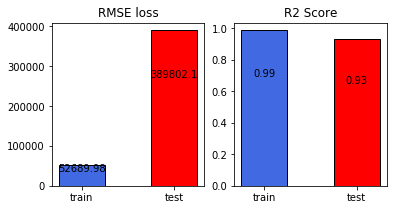

In [485]:
# split data into training, validation and test sets
X_trn,y_trn,X_test,y_test = two_split(df_drop,y)

m_com.fit(X_trn,y_trn)
result = print_score(m_com,X_trn,y_trn,X_test,y_test)
plot_score(m_com, result,val=False)

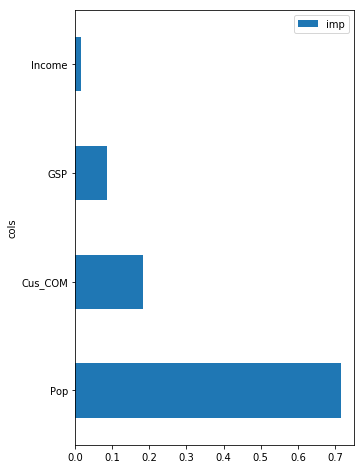

In [486]:
# calculate feature of importance
fi_com = rf_feat_importance(m_com, X_trn)
fi_com.plot('cols','imp',kind='barh',figsize=(5,8))

In [487]:
# save train model 
pickle.dump(m_com, open('model/com_model.pkl', 'wb'))

#sort fi df by X_trn columns order 
fi_com['cols'] = pd.Categorical(fi_com['cols'], X_trn.columns)
fi_com = fi_com.sort_values('cols')
# save feature of importance 
fi_com.to_csv('model/com_feature_importance.csv',index=False)

# Analyse model performance by state

I obtained are three trained ML models and three csv files with the features and the corresponding importance. I use these models to predict the total electricity consumption by state. Then analyze the model performance by state, and look at the time series prediction.

In [303]:
!dir model

 Volume in drive C is Windows
 Volume Serial Number is FC06-B52C

 Directory of C:\Users\Benny\Documents\Fern\energy\model

05/04/2019  10:03 PM    <DIR>          .
05/04/2019  10:03 PM    <DIR>          ..
05/04/2019  10:03 PM               114 com_feature_importance.csv
05/04/2019  10:03 PM         7,797,013 com_model.pkl
05/04/2019  09:42 PM               440 ind_feature_importance.csv
05/04/2019  09:42 PM       100,126,069 ind_model.pkl
05/04/2019  09:26 PM               360 res_feature_importance.csv
05/04/2019  09:26 PM       138,874,877 res_model.pkl
               6 File(s)    246,798,873 bytes
               2 Dir(s)   8,059,981,824 bytes free


In [488]:
# load model
m_res = pickle.load(open('model/res_model.pkl', 'rb'))
m_ind = pickle.load(open('model/ind_model.pkl', 'rb'))
m_com = pickle.load(open('model/com_model.pkl', 'rb'))

In [489]:
# load feature of importance 
fi_res = pd.read_csv('model/res_feature_importance.csv')
fi_ind = pd.read_csv('model/ind_feature_importance.csv')
fi_com = pd.read_csv('model/com_feature_importance.csv')

In [490]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Year-Month', 'Sale_ALL_no_OTH'],
      dtype='object')

In [494]:
def do_prediction(combine,m,fi_cols,pre_col,split=0.85):
    ''' Input
    combine: dataframe with all data
    fi_cols: columns to use for the model 
    m: trained model 
    split: percent data for test set 
    return y_predict and r-square 
    '''
    df, y, nas = proc_df(combine, pre_col,skip_flds=['Year-Month'], max_n_cat=49)
    df = df[fi_cols]
    X_trn,y_trn,X_test,y_test = two_split(df,y)
    
    y_predict = m.predict(X_test)
    score = m.score(X_test,y_test)
    return (y_predict, score)

In [495]:
# prediction for each sector
res_predict, res_score = do_prediction(combine,m_res,fi_res['cols'],'Sale_RES')
ind_predict, ind_score = do_prediction(combine,m_ind,fi_ind['cols'],'Sale_IND')
com_predict, com_score = do_prediction(combine,m_com,fi_com['cols'],'Sale_COM')

Text(0.5, 1.0, 'R-square for each sector')

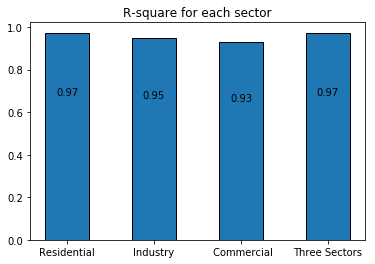

In [592]:
test_idxs = len(res_predict)
y_all_test = combine.iloc[-len(res_predict):]['Sale_ALL_no_OTH']
# over all prediction
all_predict = res_predict+ind_predict+com_predict
all_score = r2_score(y_all_test,all_predict)

x = ['Residential', 'Industry',' Commercial', 'Three Sectors']
y = [res_score,ind_score,com_score, all_score]
plt.bar(x,height=y, edgecolor ='black',width=0.5)

for i in range(len(y)):
        plt.text(s=f'{y[i].round(2)}',x=i, y=y[i].round(2)*0.7,horizontalalignment='center')
plt.title('R-square for each sector')    

In [631]:
# analyzing the prediction result
data = combine.iloc[-len(res_predict):][['Year-Month','State','Sale_RES','Sale_IND','Sale_COM','Sale_ALL_no_OTH']]
data['res_predict'] = res_predict
data['ind_predict'] = ind_predict
data['com_predict'] = com_predict
data['all_predict'] = all_predict

In [610]:
score_by_state = []
for state in data['State'].unique():
    temp = data[data['State']==state]
    score = r2_score(temp['Sale_ALL_no_OTH'],temp['all_predict'])
    score_by_state.append([state,score])

In [613]:
score_by_state = pd.DataFrame(score_by_state,columns=['State','Score']).sort_values('Score')

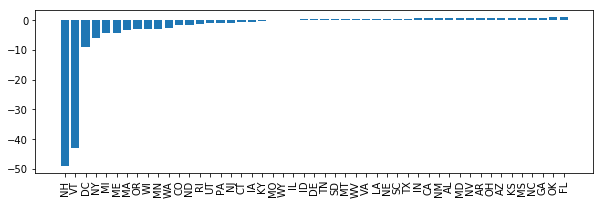

In [629]:
plt.figure(figsize=(10, 3))
plt.bar(score_by_state['State'],score_by_state['Score'])
_=plt.xticks(rotation=90)

In [632]:
select_state = ['MS', 'NC', 'GA', 'DC','VT','NH']
data = data[data['State'].isin(select_state)]
data = data.set_index('Year-Month').loc['2014-07-01':]

Text(0.5, 0.98, 'Monthly Prediction by State')

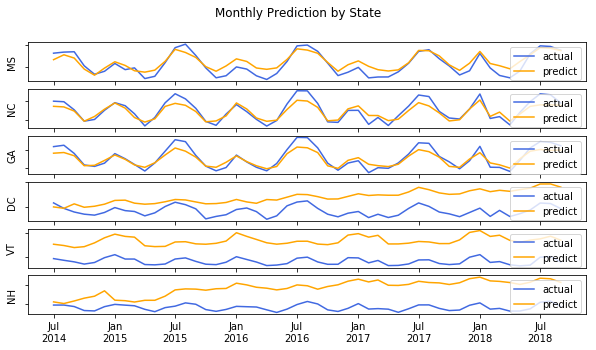

In [634]:
fig, ax = plt.subplots(6,1,figsize=(10, 5),sharex=True)

for i, state in enumerate(select_state):
    temp = data[data['State']==state]
    ax[i].plot(temp['Sale_ALL_no_OTH'],c='royalblue')
    ax[i].plot(temp['all_predict'],c='orange')
    ax[i].legend(['actual','predict'], loc='upper right')
    ax[i].axes.set_ylabel(state)
    ax[i].axes.set_yticklabels([])

ax[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
fig.suptitle('Monthly Prediction by State')

In [638]:
state_location = pd.read_html('https://inkplant.com/code/state-latitudes-longitudes')[0]
state_location['State'] = state_location['State'].replace(to_replace=us_state_abbrev)
score_by_state = score_by_state.merge(state_location,on='State')

In [639]:
correct = score_by_state[score_by_state['Score']>0.5]
incorrect = score_by_state[score_by_state['Score']<=0.5]

In [652]:
# Make an empty map
m = folium.Map(location=[40, -98], zoom_start=4, width=700, height=450)
 
# add marker one by one on the map
for i in range(0,len(correct)):
   folium.Circle(
      location=[correct.iloc[i]['Latitude'], correct.iloc[i]['Longitude']],
       popup=correct.iloc[i]['State'],
      radius=correct.iloc[i]['Score']*10000,
      color='royalblue',
      fill=True,
      fill_color='royalblue'
   ).add_to(m)


for i in range(0,len(correct)):
   folium.Circle(
      location=[incorrect.iloc[i]['Latitude'], incorrect.iloc[i]['Longitude']],
       popup=incorrect.iloc[i]['State'],
       radius= np.abs(incorrect.iloc[i]['Score'])*10000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

display(m)

In [653]:
m.save('plot2.html')